In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import DynamicEdgeConv, global_max_pool, knn_graph
import torch.optim as optim
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import plotly.graph_objects as go

from torch_geometric.data import Data

import os
import shutil
import numpy as np

import random

# Set seed
# SEED=42
# random.seed(SEED)
# torch.manual_seed(SEED)
# np.random.seed(SEED)


In [2]:

K = 4

In [3]:
class PointNetInstanceSeg(nn.Module):
    def __init__(self):
        super(PointNetInstanceSeg, self).__init__()
        self.edge_conv1 = DynamicEdgeConv(nn.Sequential(
            nn.Linear(14, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
            nn.SiLU()
        ), k=K)
        # self.edge_conv2 = DynamicEdgeConv(nn.Sequential(
        #      nn.Linear(256, 128),
        #      nn.SiLU(),
        #      nn.Linear(128, 64),
        #      nn.SiLU()
        #  ), k=K)
        # self.edge_conv3 = DynamicEdgeConv(nn.Sequential(
        #      nn.Linear(1024, 512),
        #      nn.SiLU(),
        #      nn.Linear(512, 256),
        #      nn.SiLU()
        #  ), k=8)
        # self.edge_conv4 = DynamicEdgeConv(nn.Sequential(
        #      nn.Linear(256, 256),
        #      nn.SiLU(),
        #      nn.Linear(256, 128),
        #      nn.SiLU()
        #  ), k=K)
        self.fc = nn.Linear(128, 21)  # Predicting instance mask for each point

    def forward(self, data):
        x, edge_index = data.pos, data.edge_index
        # print(data.edge_index)
        # return
        x = self.edge_conv1(x, edge_index)
        # x = self.edge_conv2(x, edge_index)
        # x = self.edge_conv3(x, edge_index)
        # x = self.edge_conv4(x, edge_index)
        x = self.fc(x)
        return x

# Calc number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(PointNetInstanceSeg())

11989

In [4]:
data = "/home/group10/deephalo_gnn/Imbalance_Resampled_for_mulltilabel/train"
files = os.listdir(data)
point_cloud_data = [(np.load(data+"/"+f)) for f in files if f.endswith(".npy")] # List of point cloud data, each element is a list of point coordinates

# Convert each point cloud data into a Data object
data_list = []
for point_cloud in point_cloud_data:
    # Create a Data object with the features
    pos = torch.tensor(point_cloud[:,:-1], dtype=torch.float)
    # Recentering positions per halo
    pos[:3] = pos[:3] - pos[:3].mean(dim=1, keepdim=True)
    data = Data(
        pos=pos,
        y = torch.eye(21)[torch.tensor(point_cloud[:,-1]+1, dtype=torch.long)],
        
    )
    
    data_list.append(data)

# Now you can use DataLoader with this list of Data objects
loader = DataLoader(data_list, batch_size=1, shuffle=True)


In [5]:
data.y
print(data.y)
class_labels = torch.argmax(data.y, dim=1)
print(class_labels)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 0, 0,  ..., 5, 5, 5])


In [6]:
labels = []
for point_clouds in point_cloud_data:
    label = point_clouds[:,-1]
    labels.append(label)
labels = torch.tensor(np.concatenate(labels))

# Calculate unique labels and counts
unique_labels, counts = torch.unique(labels, return_counts=True)

# Calculate frequencies
frequencies = counts.float() / labels.numel()

# Calculate weights
weight_vec = 1.0 / torch.log(torch.tensor(1.2) + frequencies)

In [7]:
weight_vec[0]=0.01
weight_vec
weight_vec.shape

torch.Size([21])

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_logits = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce_logits(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [9]:
DEVICE = torch.device('cuda:0')

In [10]:
def multi_label_iou(pred, target):
    pred = pred.float()
    target = target.float()

    # Reshape the tensors to a 2D format
    pred = pred.view(pred.shape[0], -1)
    target = target.view(target.shape[0], -1)

    # Calculate intersection and union for each sample
    intersection = (pred * target).sum(dim=1)
    union = (pred + target).clamp(0, 1).sum(dim=1)

    # Calculate IoU and avoid division by zero
    iou = intersection / (union + 1e-8)

    return iou.mean()

In [11]:
model = PointNetInstanceSeg().to(DEVICE)
weights = torch.FloatTensor(weight_vec).to(DEVICE)


criterion = FocalLoss(alpha=weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

loss_val = []
accu_val = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in tqdm(loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        data.to(DEVICE)
        # print(data.y.shape)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.num_graphs


    epoch_loss = running_loss / len(loader.dataset)
    accu = multi_label_iou(outputs, data.y)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    loss_val.append(epoch_loss)
    accu_val.append(accu.detach().cpu().numpy())

# Create the "ckpts" directory if it doesn't exist
import os, time

os.makedirs("ckpts", exist_ok=True)
curr_time = time.strftime("%Y%m%d-%H%M%S")
model_name = f"{curr_time}_pointnet_instance_seg"

# Save the model
torch.save(model.state_dict(), f"./ckpts/{model_name}_model.pth")

Epoch 1/15: 100%|██████████| 102/102 [00:27<00:00,  3.73it/s]


Epoch 1/15, Loss: 447.3383


Epoch 2/15: 100%|██████████| 102/102 [00:27<00:00,  3.74it/s]


Epoch 2/15, Loss: 131.3348


Epoch 3/15: 100%|██████████| 102/102 [00:27<00:00,  3.69it/s]


Epoch 3/15, Loss: 118.5124


Epoch 4/15: 100%|██████████| 102/102 [00:27<00:00,  3.68it/s]


Epoch 4/15, Loss: 92.3862


Epoch 5/15: 100%|██████████| 102/102 [00:27<00:00,  3.68it/s]


Epoch 5/15, Loss: 71.2306


Epoch 6/15: 100%|██████████| 102/102 [00:27<00:00,  3.68it/s]


Epoch 6/15, Loss: 62.5269


Epoch 7/15: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]


Epoch 7/15, Loss: 49.4529


Epoch 8/15: 100%|██████████| 102/102 [00:27<00:00,  3.68it/s]


Epoch 8/15, Loss: 48.4855


Epoch 9/15: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]


Epoch 9/15, Loss: 40.6033


Epoch 10/15: 100%|██████████| 102/102 [00:27<00:00,  3.68it/s]


Epoch 10/15, Loss: 35.8735


Epoch 11/15: 100%|██████████| 102/102 [00:27<00:00,  3.67it/s]


Epoch 11/15, Loss: 32.4484


Epoch 12/15: 100%|██████████| 102/102 [00:27<00:00,  3.69it/s]


Epoch 12/15, Loss: 27.0887


Epoch 13/15: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]


Epoch 13/15, Loss: 20.3948


Epoch 14/15: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]


Epoch 14/15, Loss: 17.9684


Epoch 15/15: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]

Epoch 15/15, Loss: 16.9429


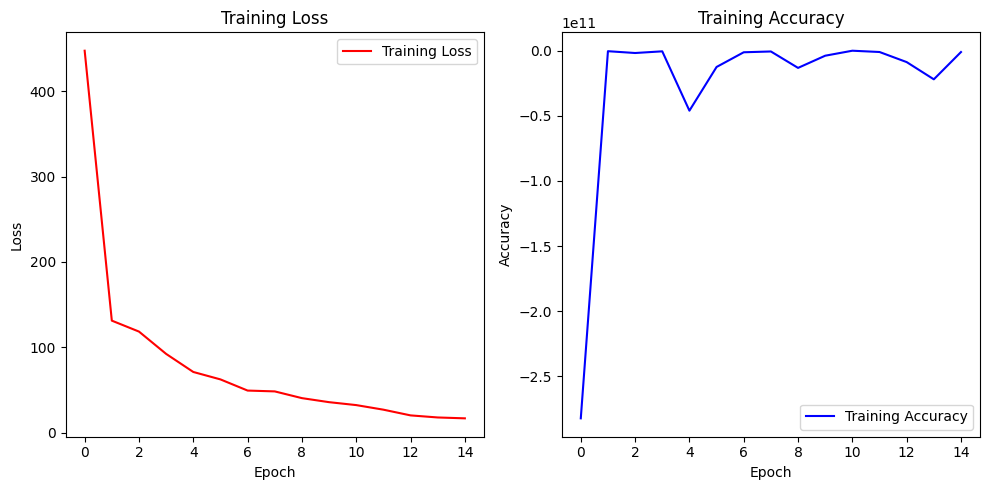

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Create the loss subplot
plt.subplot(1, 2, 1)
plt.plot(loss_val, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Create the accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(accu_val, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
data_test = "/home/group10/deephalo_gnn/Labeled subhalo matrices of haloes/test"
files = os.listdir(data_test)
point_cloud_data = [(np.load(data_test+"/"+f)) for f in files if f.endswith(".npy") and (int(f[:-4])>50)] # List of point cloud data, each element is a list of point coordinates

# Convert each point cloud data into a Data object
data_test_list = []
for point_cloud in point_cloud_data:
    # Create a Data object with the features
    data_test = Data(pos=torch.tensor(point_cloud[:,:-1], dtype=torch.float), y = torch.eye(21)[torch.tensor(point_cloud[:,-1]+1, dtype=torch.long)])
    data_test_list.append(data_test)


In [14]:

test_loader = DataLoader(data_test_list, batch_size=1, shuffle=False)
    

model.eval()

# Initialize a list to store the predictions
ground_truth_labels = []
predictions = []
pos_list = []

# Loop over the test data
with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing'):
        # Move data to the device
        data = data.to(DEVICE)
        
        # Pass the data through the model
        outputs = model(data)
        
        # Get the predicted labels
        _, predicted_labels = torch.max(outputs, 1)
        _, ground_truth = torch.max(data.y, 1)
        pos = data.pos.cpu().numpy()
        pos = pos[:,0:3]
        # Store the predictions
        ground_truth_labels.append(ground_truth.cpu().numpy())
        predictions.append(predicted_labels.cpu().numpy())
        pos_list.append(pos)
    

# At this point, `predictions` is a list of numpy arrays with the predicted labels for each point cloud in the test set
# You can now compare these predictions to the actual labels to compute your test metrics

Testing: 100%|██████████| 25/25 [00:00<00:00, 103.69it/s]


In [ ]:
hid = 0

# tar, masked = self.prep_tar(hid)
# num_masked = sum(masked)

fig = go.Figure(data=[
    go.Scatter3d(
        x=pos_list[hid][:,0],
        y=pos_list[hid][:,1],
        z=pos_list[hid][:,2],
        mode='markers',
        marker=dict(
            size=1, # Larger than surrounding data-points
            color=ground_truth_labels[hid],
            opacity=0.75,
            showscale=True,
        ))
])
fig.update_layout(
    title=f'{predictions[hid].shape} particles', title_x=0.5,
)


In [ ]:

# tar, masked = self.prep_tar(hid)
# num_masked = sum(masked)

fig = go.Figure(data=[
    go.Scatter3d(
        x=pos_list[hid][:,0],
        y=pos_list[hid][:,1],
        z=pos_list[hid][:,2],
        mode='markers',
        marker=dict(
            size=1, # Larger than surrounding data-points
            color=predictions[hid],
            opacity=0.75,
            showscale=True,
        ))
])
fig.update_layout(
    title=f'{predictions[hid].shape} particles', title_x=0.5,
)

In [17]:
iou_score = []
for idx, (gt, pred) in enumerate(zip(ground_truth_labels, predictions)):
    # Checking if the model predicts different labels for different points in the same point cloud
    # if np.unique(pred).shape[0] != 1:
    print(idx, "\t", gt.shape, "\t", np.unique(pred), "\t", np.unique(gt))
    print()
    
    iou_score.append(multi_label_iou(torch.tensor(pred), torch.tensor(gt)))

print(f"Mean acc: {np.mean(iou_score):.4f} \pm {np.std(iou_score):.4f}")

0 	 (10065,) 	 [ 0  1  3  4  5  6  8 20] 	 [0 1 2 3]

1 	 (5704,) 	 [1] 	 [0 1 2]

2 	 (14113,) 	 [1] 	 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

3 	 (7083,) 	 [ 0  1  3  6 11] 	 [0 1 2 3 4 5]

4 	 (10423,) 	 [0 1 3 6 8] 	 [0 1 2]

5 	 (6830,) 	 [1] 	 [0 1 2 3 4 5 6]

6 	 (6355,) 	 [1] 	 [0]

7 	 (13648,) 	 [1] 	 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

8 	 (12394,) 	 [ 1 18] 	 [0 1 2 3 4 5 6]

9 	 (7559,) 	 [0 1] 	 [0 1 2 3 4 5]

10 	 (16444,) 	 [1] 	 [ 0  1  2  3  4  5  6  7  8  9 10]

11 	 (6586,) 	 [ 0  2  3  4  5  6  8 20] 	 [0 1 2 3]

12 	 (9898,) 	 [1 3] 	 [0 1 2 3]

13 	 (8716,) 	 [0 1 3] 	 [0 1 2 3 4 5 6 7 8 9]

14 	 (6429,) 	 [1 3 6] 	 [0 1 2 3 4 5 6 7 8]

15 	 (15265,) 	 [ 0  1  3  6 12 13] 	 [0 1 2 3 4 5 6 7 8 9]

16 	 (18205,) 	 [1 3] 	 [ 0  1  2  3  4  5  6  7  8  9 10 11]

17 	 (13278,) 	 [1 3 6] 	 [0 1 2 3 4 5 6 7 8 9]

18 	 (15318,) 	 [ 1 18] 	 [0 1 2 3 4 5 6 7]

19 	 (6788,) 	 [ 0  1  3  6 11 13] 	 [0 1 2 3 4 5]

20 	 (9654,) 	 [1] 	 [0 1 2]

21 	 (5874,) 	 [ 0  1